# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

100%|██████████| 170498071/170498071 [00:08<00:00, 20092538.79it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

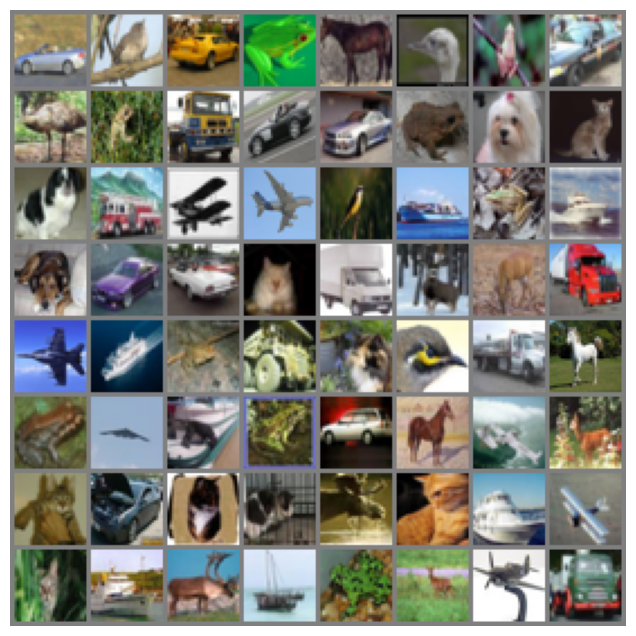

In [4]:
# Get random training images and show them.
images, labels = next(iter(train_loader))
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In this task, we need to define a CNN for the CIFAR-10 dataset. This dataset consists of 60,000 32x32 color images in 10 classes. We'll start with a simple CNN architecture with a few convolutional and pooling layers to make sure everything works. Then, we can refine the model later for better performance. 

### CNN Architecture:
We will define a simple CNN with the following structure:
1. Two convolutional layers, followed by ReLU activation and max pooling.
2. A fully connected (dense) layer to output predictions for 10 classes.

### CNN Explanation:
- `nn.Conv2d`: Applies a 2D convolution over the input signal.
- `nn.ReLU`: Applies the ReLU activation function.
- `nn.MaxPool2d`: Reduces the spatial dimensions (height and width) of the output.
- `nn.Linear`: Fully connected layer for classification.



In [5]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        # Define the layers of the network
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            
            nn.Flatten(),  # Flatten the output for fully connected layers
            nn.Linear(64 * 8 * 8, 512),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Final output layer
        )

    def forward(self, x):
        return self.network(x)

# Instantiate the model and move it to the appropriate device (CPU or GPU)
model = Model(n_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(model)

Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=4096, out_features=512, bias=True)
    (8): ReLU()
    (9): Linear(in_features=512, out_features=10, bias=True)
  )
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

For this task, we'll define the loss function and the optimizer. We'll use the `CrossEntropyLoss` which is suitable for classification problems, and an optimizer such as Adam for faster convergence.



### Loss Function and Optimizer:
- `nn.CrossEntropyLoss`: Computes the cross-entropy loss between the target and the output.
- `torch.optim.Adam`: A popular optimizer for neural networks that adapts the learning rate.


In [6]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In this assignment, we will complete the training loop. We will train the network for a small number of epochs (e.g., 2) and monitor the accuracy. Later, we can increase the number of epochs to see how much the accuracy improves.

### Training the Network:
- For each epoch, we iterate through the training data, compute the forward pass, backpropagate the loss, and update the weights.
- We will also compute the accuracy of the model on the validation set after every few steps.


In [7]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[-0.11740998 -0.07135809  0.08331022  0.05718844  0.12285199  0.00806589
  -0.03735765  0.09087209  0.07080276  0.0003629 ]
 [-0.09535802 -0.01687895  0.10126463 -0.02649365  0.09450423  0.06777886
  -0.02175762  0.09529607  0.00607883  0.01156857]]
Output probabilities:
[[0.08686262 0.09095635 0.10617068 0.10343322 0.11045296 0.09847509
  0.09410208 0.10697657 0.10485101 0.09771945]
 [0.08879002 0.0960389  0.10808273 0.09511995 0.10735451 0.10452342
  0.0955715  0.10743955 0.09826925 0.0988102 ]]


In [8]:
num_epochs = 2
validation_every_steps = 500
step = 0

train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        output = model(inputs)
        loss = loss_fn(output, targets)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            # Append average training accuracy to list
            train_accuracies.append(np.mean(train_accuracies_batches))
            train_accuracies_batches = []
            
            # Compute validation accuracy
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    predictions = output.max(1)[1]
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(targets))
                    
                model.train()
            
            # Append average validation accuracy to list
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
            
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]:.4f}")
            print(f"             validation accuracy: {valid_accuracies[-1]:.4f}")


print("Finished training.")

KeyboardInterrupt: 

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

In [ ]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [25]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [ ]:
print(f"Test accuracy: {test_accuracy:.3f}")

Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


In [ ]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

In [ ]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer:**

To improve the model's performance, we can try the following strategies: 
1. Increase the number of conolutional layers anf channels. 
2. Use dropout to prevent overfitting. 
3. Train for more epochs and adjust the learning rate

### Experiments:
1. Increased the number of channels in the convolutional layers to 128.
2. Added dropout after the fully connected layers.
3. Trained the model for 10 epochs with a learning rate of 0.0005.

In [ ]:
class ImprovedModel(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedModel, self).__init__()
        self.num_classes = num_classes
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32 -> 16x16
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 16x16 -> 8x8
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 8x8 -> 4x4
            
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout to prevent overfitting
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        return self.network(x)

# Initialize the improved model
improved_model = ImprovedModel(n_classes)
improved_model.to(device)
print(improved_model)

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).







**Question** 
### Backpropagation with a single modified neuron
Suppose we modify a single neuron in a feedforward network so that the output from the neuron is given by $f\left(\sum_j w_j x_j + b\right)$, where $f$ is some function other than the sigmoid. How should we modify the backpropagation algorithm in this case?



To modify the backpropagation algorithm for a neuron where the activation function $f$ is different from the sigmoid, the key change occurs in the computation of the gradient for that neuron. 

1. **Forward Pass**: The forward pass will compute the output of the neuron using the modified function $f$, instead of the sigmoid function. This affects the calculation of the neuron's output as:

   $$ y = f\left(\sum_j w_j x_j + b\right) $$

   where $f$ is the new activation function.

2. **Backward Pass (Gradient Calculation)**: The backpropagation algorithm involves calculating the gradient of the loss with respect to the weights. For the neuron with the modified function $f$, we need to compute the derivative of the loss with respect to $z = \sum_j w_j x_j + b$, where $z$ is the weighted sum before applying the activation function.

   In the original backpropagation, when using the sigmoid function $\sigma(z)$, the derivative of the activation function $\sigma'(z)$ would be used in the backward pass. However, now we need to use the derivative of the new activation function $f$:

   $$ \frac{\partial L}{\partial z} = \frac{\partial L}{\partial y} \cdot f'(z) $$

   where $f'(z)$ is the derivative of the new activation function and $\frac{\partial L}{\partial y}$ is the gradient of the loss with respect to the neuron's output.

3. **Weight Update**: Once the gradient with respect to the weighted sum $z$ is calculated, the rest of the backpropagation process remains unchanged. We update the weights using:

   $$ \Delta w_j = -\eta \cdot \frac{\partial L}{\partial z} \cdot x_j $$

   where $\eta$ is the learning rate.

In summary, the only change required in the backpropagation algorithm is to replace the derivative of the sigmoid function with the derivative of the new activation function $f'(z)$ when calculating the gradients during the backward pass.


**Question** 
### Backpropagation with linear neurons
Suppose we replace the usual non-linear $\sigma$ function with $\sigma(z) = z$ throughout the network. Rewrite the backpropagation algorithm for this case.


If we replace the usual non-linear activation function $\sigma(z)$ with a linear activation function $\sigma(z) = z$, the backpropagation algorithm needs to be adjusted accordingly. Here’s how:

1. **Forward Pass**: In this case, the output of each neuron is simply the weighted sum of its inputs without applying a non-linearity. The output is given by:

   $$ y = \sum_j w_j x_j + b $$

   where $y$ is the output, $w_j$ are the weights, $x_j$ are the inputs, and $b$ is the bias.

2. **Backward Pass (Gradient Calculation)**: In backpropagation, we calculate the gradient of the loss function with respect to the weights. Since the activation function is linear ($\sigma(z) = z$), its derivative is constant:

   $$ \sigma'(z) = 1 $$

   This simplifies the gradient calculation. The derivative of the loss $L$ with respect to the weighted sum $z$ is:

   $$ \frac{\partial L}{\partial z} = \frac{\partial L}{\partial y} \cdot 1 = \frac{\partial L}{\partial y} $$

   This means the gradient with respect to $z$ is directly the gradient with respect to the output $y$.

3. **Weight Update**: Once the gradient with respect to $z$ is computed, the weights are updated as usual using gradient descent:

   $$ \Delta w_j = -\eta \cdot \frac{\partial L}{\partial z} \cdot x_j $$

   where $\eta$ is the learning rate. Since $\frac{\partial L}{\partial z}$ is the same as $\frac{\partial L}{\partial y}$, we can directly use the gradient of the loss with respect to the output $y$ to update the weights.

In summary, with linear activation functions $\sigma(z) = z$, the backpropagation algorithm becomes simpler because the derivative of the activation function is $1$. The rest of the algorithm, including weight updates and error propagation, remains the same.
